<a href="https://colab.research.google.com/github/parthasarathydNU/gen-ai-coursework/blob/main/advanced-llms/CourseWork/INFO_7374_Lecture_3_Complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn as nn
from torch.nn import functional as F
from torch import optim

# Vanilla Transformer

## Self Attention Review

Self Attention creates contextualized token features using the features from its context

![](http://jalammar.github.io/images/t/transformer_self-attention_visualization.png)


![](http://jalammar.github.io/images/t/self-attention-output.png)

![](http://jalammar.github.io/images/t/self-attention-matrix-calculation-2.png)


<!-- ![](https://i.ibb.co/wN24cJV/Screenshot-2024-01-27-at-11-56-04-PM.png) -->

In [ ]:
from torch import nn as nn
class SelfAttentionHead(nn.Module):
    """ one head of self-attention """
    def __init__(self):
        super().__init__()
        self.k_proj = nn.Linear(2, 2, bias=False)
        self.q_proj = nn.Linear(2, 2, bias=False)
        self.v_proj = nn.Linear(2, 2, bias=False)

    def forward(self, x):
        batch, timesteps, channels = x.shape
        key = self.k_proj(x)
        query = self.q_proj(x)
        value = self.v_proj(x)

        attention = query @ key.transpose(-2,-1) * channels**-0.5

        mask = torch.tril(torch.ones(timesteps, timesteps))
        masked_attention = attention.masked_fill(mask == 0, float('-inf'))
        masked_attention = F.softmax(masked_attention, dim=-1)

        # perform the weighted aggregation of the values
        out = masked_attention @ value
        return out

## MultiHead Attention

Conceptually, think of multi-head attention as a team of experts where each member focuses on a different aspect of the problem, combining their insights to arrive at a more comprehensive understanding.

![](http://jalammar.github.io/images/t/transformer_attention_heads_qkv.png)

![](http://jalammar.github.io/images/t/transformer_attention_heads_z.png)

![](http://jalammar.github.io/images/t/transformer_multi-headed_self-attention-recap.png)

8 x (4, 8, 2) # (BATCH, SEQUENCE_LENGTH, FEATURES)

stack along last dimension (feature dim)

output of MHA after concatenation: (4, 8, 16)

(4, 8, 16) -> Linear(16, 2) -> (4, 8, 2)



## Positional Encodings


![](http://jalammar.github.io/images/t/transformer_positional_encoding_example.png)


Question: Do the position embeddings and the token embeddings need to be the same size?

### Sinusoidal Position Encodings
![](https://erdem.pl/static/88272d0cec92896a91fc252b66f4faab/21b4d/position-values-20.png)
![](https://miro.medium.com/v2/resize:fit:1044/1*fX8TN02pB5G1pLNsJIC6QA.png)

Each dimension of the positional embedding alternates between sine and cosine. If you decide for your position embedding dimension to be 5, for each position in your sequence, you will calculate a positional embedding value for that position. $i$ is the dimension.

1. For even values of $i$ (like 0 and 2), you use the sine function
2. For odd values of $i$, (like 1 and 3), you use the cosine function


\begin{align*}
PE(pos, 0) &= \sin\left(\frac{pos}{10000^{0/5}}\right) \\
PE(pos, 1) &= \cos\left(\frac{pos}{10000^{0/5}}\right) \\
PE(pos, 2) &= \sin\left(\frac{pos}{10000^{2/5}}\right) \\
PE(pos, 3) &= \cos\left(\frac{pos}{10000^{2/5}}\right) \\
PE(pos, 4) &= \sin\left(\frac{pos}{10000^{4/5}}\right)
\end{align*}

#### Drawbacks
Scaling Issues: For very long sequences, the sinusoidal waves can become very compressed, leading to less distinct positional representations, which might affect the model's ability to distinguish position information effectively.

Generalization to Unseen Lengths: While sinusoidal embeddings can, in theory, generalize to sequence lengths beyond those seen during training, their effectiveness in doing so can be limited, especially for significantly longer sequences.

In [ ]:
import torch
import math

def sinusoidal_position_encoding(seq_len, d_model):
    position = torch.arange(seq_len).unsqueeze(1).float()  # Shape: [seq_len, 1]
    i = torch.arange(0, d_model, step=2).float()  # Even indices

    # The original paper uses the formula 1 / (10000^(2i/d_model))
    # for the denominator.
    div_term = torch.pow(10000.0, i / d_model)  # Shape: [d_model // 2]

    # Initialize the positional encoding with zeros
    pe = torch.zeros(seq_len, d_model)

    # Apply the sinusoidal encoding
    pe[:, 0::2] = torch.sin(position / div_term)  # for all positions, we want sine for even indices
    pe[:, 1::2] = torch.cos(position / div_term)  # for all positions, we want cosine for odd indices

    return pe

# Example usage
seq_len = 100  # sequence length
d_model = 512  # dimension of the model
position_encoding = sinusoidal_position_encoding(seq_len, d_model)


In [ ]:
torch.arange(0, 128, step=2)

tensor([  0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,  26,
         28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,  52,  54,
         56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,  78,  80,  82,
         84,  86,  88,  90,  92,  94,  96,  98, 100, 102, 104, 106, 108, 110,
        112, 114, 116, 118, 120, 122, 124, 126])

### Absolute Position Encodings
Similar implementation to word embeddings. Instead of using a token id, we use the position directly.

#### Drawbacks
Cannot extrapolate to longer lengths

In [ ]:
import torch
torch.arange(10)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, max_seq_len, embedding_dim):
        super(PositionalEncoding, self).__init__()
        self.positional_embeddings = nn.Embedding(max_seq_len, embedding_dim)

    def forward(self, x):
        positions = torch.arange(0, x.size(1)).unsqueeze(0)
        positions = positions.to(x.device)
        position_embeddings = self.positional_embeddings(positions)
        return x + position_embeddings

# Example usage
max_seq_len = 100  # Adjust as needed
embedding_dim = 512  # Should match your model's dimension
pos_encoder = PositionalEncoding(max_seq_len, embedding_dim)

# Dummy input tensor representing a batch of sequences
input_tensor = torch.randn(32, max_seq_len, embedding_dim)  # Batch size 32, Sequence length 100, Embedding dim 512

# Apply positional encoding
encoded = pos_encoder(input_tensor)

print(encoded.shape)


torch.Size([32, 100, 512])


<!-- ## Dropout
![](https://python-course.eu/images/machine-learning/weights_input2hidden_dropout_i2_800w.webp)


Dropout is a regularization technique used in neural networks to prevent overfitting. It works by randomly "dropping out" (i.e., setting to zero) a number of output features of the layer during training.

During training, randomly selected neurons are ignored or "dropped out."
This means their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass.

As a result, the network becomes less sensitive to the specific weights of neurons. This leads to a network that is capable of better generalization and is less likely to overfit to the training data.

### Scaling

Dropout randomly sets a fraction of input units to zero during training to prevent overfitting. However, this changes the expected sum of the inputs to the next layer. To compensate, outputs are scaled by a factor of $\frac{1}{1-p}$
during training, where $p$ is the dropout probability. This scaling ensures that the sum of the inputs during training and inference (when dropout is not applied) remains approximately the same. This helps maintain the overall activation levels consistent across both phases.

### Train/Test

Dropout is only used during training. During evaluation or inference, dropout is not applied. Note that when we call `model.train()` or `model.eval()`, PyTorch will help us turn on/off dropout automatically -->

## Normalization

### LayerNorm (used in the original transformer)

Normalizes the inputs across the features for each sample independently.
Computes the mean and variance used for normalization from all of the summed inputs to the neurons in a layer on a single training sample.

$$y = \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} \times \gamma + \beta$$

Where $x$ is the input, $\mu$ is the mean, $\sigma^2$ is the variance, $\epsilon$ is a small constant and $\gamma$ and $\beta$ are learnable parameters for scaling and shifting.


In [ ]:
from torch import nn as nn

batch, sentence_length, embedding_dim = 20, 5, 10
embedding = torch.randn(batch, sentence_length, embedding_dim)

# embedding dim is the input shape, we want to normalize all feature of
layer_norm = nn.LayerNorm(embedding_dim)

# using the layer norm
layer_norm(embedding).shape

torch.Size([20, 5, 10])

### RMSNorm (used by llama)

A variation of LayerNorm, RMSNorm normalizes the inputs using the root mean square (RMS) value instead of the mean and variance.

Intended to provide a simpler and more efficient computation than LayerNorm, especially in terms of memory and computational requirements.

$$y = \frac{x}{\sqrt{\frac{1}{N}\sum_{i=1}^{N}x_i^2 + \epsilon}} \times \gamma
$$

Where $x$ is the input, $N$ is the number of inputs, $\epsilon$ is a small constant for numerical stability, and $\gamma$ is a learnable scaling parameter


In [ ]:
from torch import nn
# official implementation: https://github.com/bzhangGo/rmsnorm/blob/master/rmsnorm_torch.py
class RMSNorm(nn.Module):
    def __init__(self, n):
        self.n = n
        scale = nn.Parameter(torch.ones(d))
        self.register_parameter(scale, self.scale)

    def forward(self, x):
        x_normed = F.normalize(x, p=2, dim=-1) * ( (1/self.n) ** -0.5)
        # x_normed = F.normalize(x, p=2, dim=-1) * (self.n ** 0.5) # equivalent

        return self.scale * x_normed

# Sampling
<!-- ![](https://i.ibb.co/fddncgs/Screenshot-2024-01-24-at-4-03-45-PM.png) -->

## Greedy Decoding
![](https://files.readme.io/2a0cc2f-Top-KTop-P_Visual_3.png)

In [ ]:
import numpy as np

def greedy_decode(probabilities):
    return np.argmax(probabilities)

# Example usage
probabilities = np.array([0.1, 0.3, 0.6])
decoded_index = greedy_decode(probabilities)

print("Decoded Index:", decoded_index)


Decoded Index: 2


## Top P Sampling (Nucleus sampling)
![](https://files.readme.io/fb9c5f9-Top-KTop-P_Visual_6.png)

In [ ]:
import numpy as np

def top_p_sampling(probabilities, p=0.9):
    """
    Selects tokens from a probability distribution that have a cumulative probability
    greater than the threshold p.

    :param probabilities: A 1D numpy array containing the probability distribution.
    :param p: The cumulative probability threshold (0 < p <= 1).
    :return: An index sampled according to the top-p distribution.
    """
    print(f"{probabilities=}")
    # Sort probabilities in descending order and also get the original indices
    sorted_indices = np.argsort(probabilities)[::-1]
    print(f"{sorted_indices=}")
    sorted_probabilities = probabilities[sorted_indices]

    print(f"{sorted_probabilities=}")

    # Compute cumulative probabilities
    cumulative_probabilities = np.cumsum(sorted_probabilities)
    print(f"{cumulative_probabilities=}")

    # Find the threshold index
    cutoff_index = np.where(cumulative_probabilities > p)[0][0]
    print(f"{cutoff_index=}")

    # Filter out indices and probabilities that don't meet the threshold
    filtered_indices = sorted_indices[:cutoff_index + 1]
    print(f"{filtered_indices=}")
    filtered_probabilities = sorted_probabilities[:cutoff_index + 1]
    print(f"{filtered_probabilities=}")

    # Normalize the filtered probabilities
    filtered_probabilities /= filtered_probabilities.sum()
    print(f"normalized_filtered_probabilities{filtered_probabilities}")

    # Sample from the filtered distribution
    chosen_index = np.random.choice(filtered_indices, p=filtered_probabilities)

    return chosen_index

# Example usage
probabilities = np.array([0.4, 0.1, 0.2, 0.3])
selected_index = top_p_sampling(probabilities, p=0.7)

print("Selected Index:", selected_index)


probabilities=array([0.4, 0.1, 0.2, 0.3])
sorted_indices=array([0, 3, 2, 1])
sorted_probabilities=array([0.4, 0.3, 0.2, 0.1])
cumulative_probabilities=array([0.4, 0.7, 0.9, 1. ])
cutoff_index=2
filtered_indices=array([0, 3, 2])
filtered_probabilities=array([0.4, 0.3, 0.2])
normalized_filtered_probabilities[0.44444444 0.33333333 0.22222222]
Selected Index: 3


## Top K Sampling
![](https://files.readme.io/8beb940-Top-KTop-P_Visual_4.png)
![](https://files.readme.io/1810654-Top-KTop-P_Visual_5.png)

In [ ]:
import numpy as np

def top_k_sampling(probabilities, k=5):
    """
    Performs top-k sampling from a probability distribution.

    :param probabilities: A 1D numpy array containing the probability distribution.
    :param k: The number of top elements to consider for sampling.
    :return: An index sampled from the top-k distribution.
    """
    # Get indices of the top k probabilities
    top_k_indices = np.argsort(probabilities)[-k:]

    # Extract the top k probabilities
    top_k_probabilities = probabilities[top_k_indices]

    # Normalize the top k probabilities so they sum to 1
    top_k_probabilities /= top_k_probabilities.sum()

    # Sample from the top k elements
    chosen_index = np.random.choice(top_k_indices, p=top_k_probabilities)

    return chosen_index

# Example usage
probabilities = np.array([0.1, 0.2, 0.3, 0.4])
selected_index = top_k_sampling(probabilities, k=2)

print("Selected Index:", selected_index)


Selected Index: 2



## Temperature
![](https://txt.cohere.com/content/images/size/w1000/2023/03/LLM-parameters-demystified.jpg)

$$P_{\text{temp}}(y_i) = \frac{e^{\frac{z_i}{T}}}{\sum_{j} e^{\frac{z_j}{T}}}$$


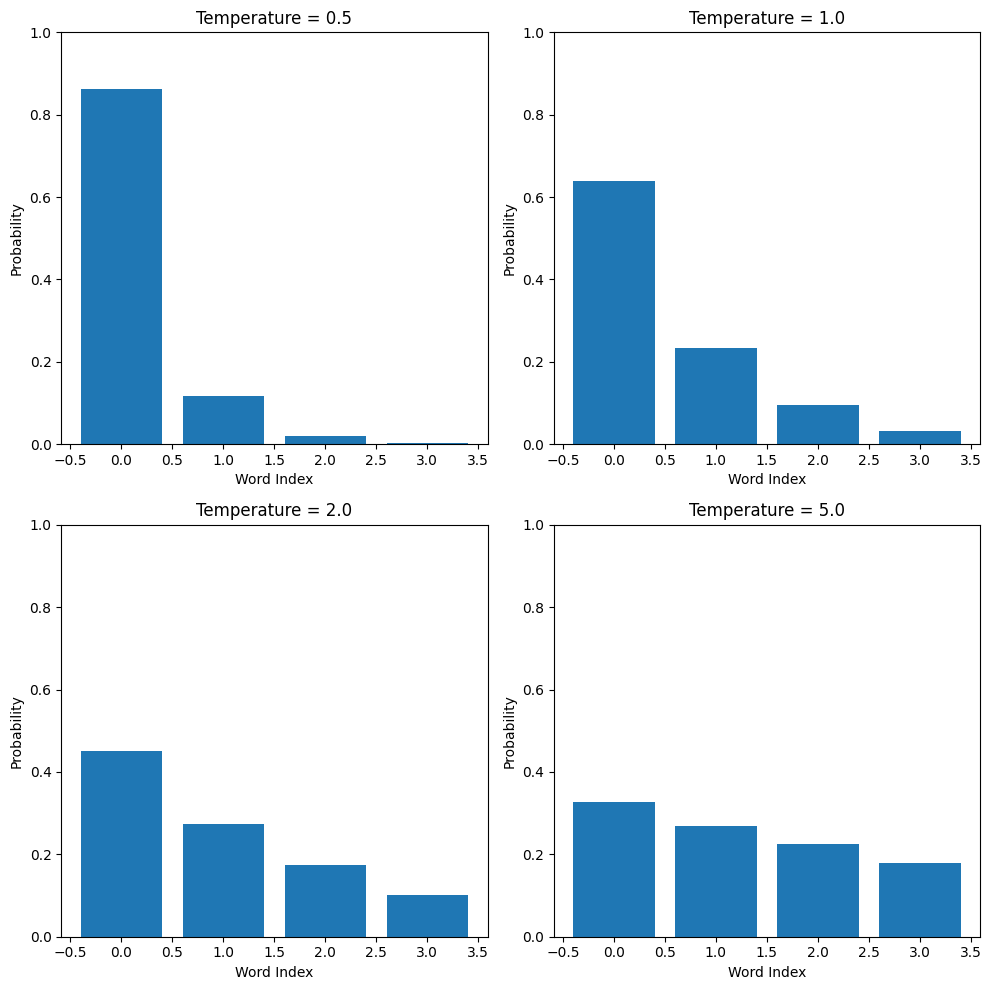

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def softmax(logits, temperature=1.0):
    scaled_logits = logits / temperature
    exp_logits = np.exp(scaled_logits - np.max(scaled_logits))  # For numerical stability
    probabilities = exp_logits / np.sum(exp_logits)
    return probabilities

# Example logits from a language model's output
logits = np.array([2.0, 1.0, 0.1, -1.0])


temperatures = [0.5, 1.0, 2.0, 5.0]
plt.figure(figsize=(10, 10))

for i, T in enumerate(temperatures):
    probabilities = softmax(logits, T)
    plt.subplot(2, 2, i + 1)
    plt.bar(range(len(logits)), probabilities)
    plt.title(f"Temperature = {T}")
    plt.xlabel("Word Index")
    plt.ylabel("Probability")
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()

## Repetition Penalty

How it Works:

When a word is generated, its future probability is decreased.
**For** example, if "sunshine" is generated, its score is reduced in subsequent steps.
This is done by multiplying the word's score by a factor (e.g., 0.7) before softmax.

Example:

Original score for "sunshine": 5.

Apply penalty:

new score = 5 × 0.7 = 3.5
Reduced score leads to a lower probability after softmax.

$\text{new score} = \text{original score} \times \text{penalty factor}$

This method helps prevent repetitive text, encouraging more diverse and natural language generation.

## Special Tokens



In [ ]:
<user>what is the capital of france?</user>
<assistant>paris</assistant>
<user>what is the capital of france?</user>
<assistant>paris</assistant>
<user>what is the capital of france?</user>
<assistant>paris</assistant>
<user>what is the capital of france?</user>
<assistant>paris</assistant>

<sys>your role</sys>

SyntaxError: invalid syntax (<ipython-input-1-28a1557c0df8>, line 1)


<!-- ![](https://i.ibb.co/tDMM9zN/Screenshot-2024-01-24-at-9-04-17-PM.png) -->

Special tokens in language models serve specific purposes:

System Tokens: These are tokens used to control model behavior or provide specific instructions. For example, in GPT models, system tokens might be used to switch between different modes of text generation, like summarization or translation.

Role Tokens (User, Assistant): These tokens indicate the speaker in a conversation. For instance, "user" might precede text generated by the user, and "assistant" for text generated by the AI model. This helps in distinguishing between different speakers in a dialogue, maintaining the flow and context of the conversation.

EOS Tokens: "End of Sentence" (EOS) tokens signify the end of a text sequence. When a language model generates an EOS token, it indicates that the sentence or text segment is complete. This helps in determining when to stop generating further text in tasks like translation or chatbot responses.
Both types of tokens are crucial for guiding the language model's generation process and ensuring coherent and contextually appropriate outputs.

# Modern GPTs

(online)

## Positional Embeddings

* absolute position embeddings: have generalization issues if you try to run something is longer that what it has seen before, you will need to start chopping off context just to be able to run it. this is what we are using in the assignments. also you do not model how close words are. One prior, is that tokens that are closer together than tokens that are further away from each other.

* RoPE
* Alibi: add something to attention values. value is scaled by how far away the key is away from query token.


### RoPE Embeddings (meta llama)

Unlike traditional position embeddings, which add separate position vectors to token embeddings, RoPE integrates positional information directly into the attention mechanism. This is achieved by rotating the token embeddings based on their positions before computing self-attention.

1. Rotation-Based Encoding: RoPE rotates each token embedding in a way that depends on its position, effectively encoding the position into the embedding itself.
2. Preservation of Relative Position: This method maintains relative positional information, allowing the model to better understand the order of tokens.
3. Integration with Self-Attention: By altering the token embeddings before they are fed into the self-attention mechanism, RoPE simplifies the model's ability to incorporate positional information.
4. Efficiency and Scalability: This approach can be more efficient and scalable compared to traditional position embeddings, as it avoids the need for additional positional parameters.

<!-- ![](https://i.ibb.co/DWzvvdM/Screenshot-2024-01-29-at-7-59-41-AM.png) -->
![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*Bz0z7dYRTfNo5uGPpAWKtw.png)
<!-- ![](https://i.ibb.co/xfKkdHW/Screenshot-2024-01-29-at-8-00-39-AM.png) -->

$R(\theta) = \begin{bmatrix} \cos(\theta) & -\sin(\theta) \\ \sin(\theta) & \cos(\theta) \end{bmatrix} [x1, x2]$

x1 cos(theta) -x2 *sin(theta)

x1 sin(theta) + x2 cos(theta)







#### 2D Rotation Matrix
In 2D space, a rotation matrix looks like this:
$R(\theta) = \begin{bmatrix} \cos(\theta) & -\sin(\theta) \\ \sin(\theta) & \cos(\theta) \end{bmatrix}$
Here, $\theta$ is the angle of rotation. This matrix rotates a vector by $\theta$ degrees counterclockwise.

**Multiplying a Vector**

If you have a vector (like a point on a graph), $\mathbf{v} = \begin{bmatrix} x \\ y \end{bmatrix}$, multiplying it by this matrix rotates it:
$\mathbf{v'} = R(\theta) \mathbf{v}$

The result, $\mathbf{v'}$, is the new, rotated position of the vector.


**Rotation Matrix for 30 Degrees**

The rotation matrix for a 30-degree (or $\pi/6$ radians) counterclockwise rotation is:

$R(30^\circ) = \begin{bmatrix} \cos(30^\circ) & -\sin(30^\circ) \\ \sin(30^\circ) & \cos(30^\circ) \end{bmatrix} = \begin{bmatrix} \cos(\pi/6) & -\sin(\pi/6) \\ \sin(\pi/6) & \cos(\pi/6) \end{bmatrix}$

**Original Point (1,0)**

The vector representation of the point (1,0) is:

$\mathbf{v} = \begin{bmatrix} 1 \\ 0 \end{bmatrix}$

**Applying the Rotation**
Multiply the rotation matrix by the vector:

$\mathbf{v'} = R(30^\circ)$

$\mathbf{v} = \begin{bmatrix} \cos(\pi/6) & -\sin(\pi/6) \\ \sin(\pi/6) & \cos(\pi/6) \end{bmatrix} \begin{bmatrix} 1 \\ 0 \end{bmatrix}$

**Resulting Point**

Simplifying the multiplication, we get the new position of the point:

$\mathbf{v'} = \begin{bmatrix} \cos(\pi/6) \\ \sin(\pi/6) \end{bmatrix} = \begin{bmatrix} \sqrt{3}/2 \\ 1/2 \end{bmatrix}$

This is the new position of the point after a 30-degree rotation.





<!-- $R^d_{\theta, m} = \left(\begin{array}{cccccc}
\cos m\theta_1 & -\sin m\theta_1 & 0 & \cdots & 0 & 0 \\
\sin m\theta_1 & \cos m\theta_1 & 0 & \cdots & 0 & 0 \\
0 & 0 & \cos m\theta_2 & -\sin m\theta_2 & \cdots & 0 \\
0 & 0 & \sin m\theta_2 & \cos m\theta_2 & \cdots & 0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & 0 & \cos m\theta_{d/2} & -\sin m\theta_{d/2} \\
0 & 0 & 0 & 0 & \sin m\theta_{d/2} & \cos m\theta_{d/2}
\end{array}\right)$ -->


For larger dimensions, we do the same operator to every pair of features


$
R^d_{\theta,m} \mathbf{x} = \left( \begin{array}{c}
x_1 \\
x_2 \\
x_3 \\
x_4 \\
\vdots \\
x_{d-1} \\
x_d
\end{array} \right) \otimes \left( \begin{array}{c}
\cos m\theta_1 \\
\cos m\theta_1 \\
\cos m\theta_2 \\
\cos m\theta_2 \\
\vdots \\
\cos m\theta_{d/2} \\
\cos m\theta_{d/2}
\end{array} \right) + \left( \begin{array}{c}
-x_2 \\
x_1 \\
-x_4 \\
x_3 \\
\vdots \\
-x_{d-1} \\
x_d
\end{array} \right) \otimes \left( \begin{array}{c}
\sin m\theta_1 \\
\sin m\theta_1 \\
\sin m\theta_2 \\
\sin m\theta_2 \\
\vdots \\
\sin m\theta_{d/2} \\
\sin m\theta_{d/2}
\end{array} \right)
$


$$θ_i = 10000^{−2i/d}$$

x1 cos(theta) -x2 *sin(theta)

 x2 cos(theta) + x1 sin(theta)

In [ ]:
import torch
from torch import nn as nn

def rotate_half(x):
    x1, x2 = x.chunk(2, dim=-1)
    return torch.cat((-x2, x1), dim=-1)

def apply_rotary_pos_emb(q, k, cos, sin):
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

#### Rope Position Interpolation

At inference time we can feed in different values that we saw during training. In particular, instead of using $m\theta$ as our angle, we can do $\frac{1}{4}m\theta$ and see good results. This effectively extends our context by 4x since we can train on up to 8k context and do inference on up to 32k!


[hf implementation](https://github.com/huggingface/transformers/blob/8e164c5400b7b413c7b8fb32e35132001effc970/src/transformers/models/llama/modeling_llama.py#L124-L128)

### Alibi Position Embeddings (mosaic mpt)

Attention With Linear Biases

$m$ is head-specific not trainable parameter. The idea is that different heads can be more/less about immedidate token neighborhood

![](https://miro.medium.com/v2/resize:fit:1062/1*9D_DIgDJz5WQbreZ1a9xTA.png)

In [ ]:
import torch
from torch import nn


class Alibi(nn.Module):
    def __init__(self, m, seq_len):
        super().__init__()
        self.m = m
        tril = torch.tril(torch.ones(seq_len, seq_len))
        self.alibi = -torch.cumsum(tril, 0)

        self.register_buffer('alibi_pe', self.alibi)

    def forward(self, x):
        return x + self.m *self.alibi



seq_len = 4

alibi = Alibi(m=0.01, seq_len=seq_len)

zeros = torch.zeros((seq_len, seq_len))
print(alibi(zeros))


batch = 4
batched_query_dot_key = torch.tril(torch.randn((batch, seq_len, seq_len)))
print(alibi(batched_query_dot_key))


tensor([[-0.0100,  0.0000,  0.0000,  0.0000],
        [-0.0200, -0.0100,  0.0000,  0.0000],
        [-0.0300, -0.0200, -0.0100,  0.0000],
        [-0.0400, -0.0300, -0.0200, -0.0100]])
tensor([[[-1.7279,  0.0000,  0.0000,  0.0000],
         [ 1.0847, -1.5766,  0.0000,  0.0000],
         [ 0.4823,  0.2532,  0.0222,  0.0000],
         [-0.8694,  0.9100, -0.9984, -1.0275]],

        [[ 0.8839,  0.0000,  0.0000,  0.0000],
         [-0.8806,  0.3302,  0.0000,  0.0000],
         [-0.8325,  0.4510,  0.3548,  0.0000],
         [-0.7117, -0.5995,  0.0068, -0.6867]],

        [[-0.1045,  0.0000,  0.0000,  0.0000],
         [-0.4575,  1.0201,  0.0000,  0.0000],
         [ 0.9982, -0.3955, -0.7383,  0.0000],
         [ 1.5227, -0.0917,  0.8196, -0.5769]],

        [[ 1.5433,  0.0000,  0.0000,  0.0000],
         [ 0.5655, -0.2667,  0.0000,  0.0000],
         [-1.1370, -0.3153, -0.8158,  0.0000],
         [ 0.5065, -0.3080,  0.4517,  1.3569]]])


## Normalization

### RMSNorm (used by llama)

A variation of LayerNorm, RMSNorm normalizes the inputs using the root mean square (RMS) value instead of the mean and variance.

Intended to provide a simpler and more efficient computation than LayerNorm, especially in terms of memory and computational requirements.

$$y = \frac{x}{\sqrt{\frac{1}{N}\sum_{i=1}^{N}x_i^2 + \epsilon}} \times \gamma
$$

Where $x$ is the input, $N$ is the number of inputs, $\epsilon$ is a small constant for numerical stability, and $\gamma$ is a learnable scaling parameter


In [ ]:
# official implementation: https://github.com/bzhangGo/rmsnorm/blob/master/rmsnorm_torch.py
class RMSNorm(nn.Module):
    def __init__(self, n):
        self.n = n
        self.scale = nn.Parameter(torch.ones(d))
        self.register_parameter(self.scale, self.scale)

    def forward(self, x):
        x_normed = F.normalize(x, p=2, dim=-1) * ( (1/self.n) ** -0.5)
        # x_normed = F.normalize(x, p=2, dim=-1) * (self.n ** 0.5) # equivalent

        return self.scale * x_normed

## Architecture
* MultiQueryAttention: Multi Query attention is a change to the model architecture that shrinks the size of the KV cache by assigning multiple heads to Q, and only a single head to K and V. It needs to be trained into the model from the beginning
* GroupedQueryAttention: In between MultiHeadAttention and MultiQueryAttention. Using a single key-value per subgroup of query heads.


![](https://miro.medium.com/v2/resize:fit:1400/1*VDWPMgjQzFEgiTHcL5-9fw.png)

Question: Can you rank these variants from least to most compute intensive?

In [ ]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F
import time
import math

class Attention(nn.Module):
    def __init__(self, dim_size:int=64) -> None:
        super().__init__()
        self.dim_size = dim_size
        self.query = nn.Linear(in_features=dim_size, out_features=dim_size)
        self.key  = nn.Linear(in_features=dim_size, out_features=dim_size)
        self.value = nn.Linear(in_features=dim_size, out_features=dim_size)

    def self_attention(self, Q:Tensor, K:Tensor, V:Tensor) -> Tensor:
        d_k = Q.size(-1)
        score = Q @ K.transpose(-2, -1) / math.sqrt(d_k)
        score = torch.softmax(score, dim=-1)
        Z = score @ V
        return Z

    def forward(self, x:Tensor) -> Tensor:
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        Z = self.self_attention(Q, K, V)
        return Z


class MultiheadAttention(nn.Module):
    r"""
    https://arxiv.org/abs/1706.03762
    """
    def __init__(self, dim_size: int = 64, n_head:int=8) -> None:
        super().__init__()
        self.n_head = n_head
        self.dim_size = dim_size
        self.proj = nn.Linear(in_features=dim_size * n_head, out_features=dim_size)
        self.multihead = nn.ModuleList([
            Attention(dim_size) for _ in range(n_head)
        ])

    def forward(self, x: Tensor) -> Tensor:
        Z_s = torch.cat([head(x) for head in self.multihead], dim=-1)
        Z = self.proj(Z_s)
        return Z


class  MultiQueryAttention(Attention):
    r"""
    https://arxiv.org/pdf/1911.02150.pdf
    """
    def __init__(self, dim_size: int = 64, n_query:int=8) -> None:
        super().__init__(dim_size)
        self.n_query = n_query
        self.proj = nn.Linear(in_features=dim_size * n_query, out_features=dim_size)
        self.queries = nn.ModuleList([
            nn.Linear(in_features=dim_size, out_features=dim_size)
            for _ in range(n_query)
        ])

    def forward(self, x: Tensor) -> Tensor:
        K = self.key(x)
        V = self.value(x)
        Z_s = torch.cat([
            self.self_attention(query(x), K, V) for query in self.queries
        ], dim=-1)
        Z = self.proj(Z_s)
        return Z


class  GroupedQueryAttention(Attention):
    """
    https://arxiv.org/pdf/2305.13245.pdf
    """
    def __init__(
            self,
            dim_size: int = 64,
            n_groups: int = 4,
            group_size: int=2
        ) -> None:
        super().__init__(dim_size)

        self.grouped = nn.ModuleList([
            MultiQueryAttention(dim_size, n_query=group_size)
            for _ in range(n_groups)
        ])
        self.proj = nn.Linear(in_features=n_groups*dim_size, out_features=dim_size)

    def forward(self, x: Tensor) -> Tensor:
        Z_s = torch.cat([head(x) for head in self.grouped], dim=-1)
        Z = self.proj(Z_s)
        return Z


## Evaluation

### Perplexity

Perplexity is a metric used to measure how well a probabilistic model predicts a sample. It's commonly used in natural language processing to evaluate language models. Perplexity is defined as the exponentiation of the average negative log-likelihood of a sequence of tokens.

Perplexity of a language model for a sequence of tokens is defined as:

\begin{equation}
    \text{Perplexity} = \exp\left(\frac{\sum_{i=1}^{N} -\log P(w_i)}{N}\right)
\end{equation}

where $P(w_i)$ is the probability of the $i$-th token in the sequence and $N$ is the total number of tokens in the sequence.



Perplexity: 4.518010018049224


![](https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F6b8169ae-0337-41d6-a4dd-1c15a4e31b79_1200x914.png)


## Data

### Internet
[red pajama](https://www.together.ai/blog/redpajama-data-v2)

[refined web](https://arxiv.org/pdf/2306.01116.pdf)


### Phi -- Textbooks are all you need

#### Data

Synthetic code exercises:

![](https://i.imgur.com/yGDoyKd.png)

Synthetic code textbooks

![](https://i.imgur.com/O4l7VHT.png)

Filtered open-source

<!-- ![](https://i.ibb.co/t37zYBh/Screenshot-2024-01-25-at-10-50-24-AM.png)





![](https://i.ibb.co/LnhMQGS/Screenshot-2024-01-25-at-10-49-01-AM.png) -->

![](https://i.imgur.com/b9Ftk7i.png)

![](https://miro.medium.com/v2/resize:fit:1400/1*wiNeStO5x06iLks7WQWKxw.png)


![](https://miro.medium.com/v2/resize:fit:1400/1*tBr1LW5uee7NyG9QgB3eeQ.png)


## BPE Tokenizer

A tokenizer may not be suitable if it has been trained on text that is different from the one you will use to train a model from scratch

for example:
* new language
* new characters
* new domain


Training a tokenizer is different from training a model. A model uses gradient descent. Training a tokenizer is a statistical process that tries to identify which subwords are best to pick for a given corpus, and the way the subwords are chosen depend on the tokenization algorith. It is deterministic.


Byte Pair Encoding (BPE) works by iteratively merging the most frequent pair of adjacent symbols (bytes or characters) in a text dataset to form new symbols. This process continues until a specified vocabulary size is reached, effectively encoding more frequent sequences as single units and reducing the overall number of tokens needed to represent the text.


### Implementing BPE

In [ ]:
corpus = [
    "The sun shines brightly.",
    "Cats love to sleep.",
    "Python is a versatile language.",
    "Music brings joy.",
    "The ocean is vast and deep.",
    "Books are windows to the world.",
    "Space exploration inspires imagination.",
    "Art transcends boundaries.",
    "Technology advances rapidly.",
    "Dreams fuel progress."
]

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Next, we need to pre tokenize that corpus into words.

The character Ġ is used in place of a space. This is way to tell the model taht it is the beginning of a new word. Note that we do not add it to beginning of a sentence, because often there is a `<S>` or `<bos>` start token so additionally adding Ġ would be unnecessary.

In [ ]:
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(corpus[0])

[('The', (0, 3)),
 ('Ġsun', (3, 7)),
 ('Ġshines', (7, 14)),
 ('Ġbrightly', (14, 23)),
 ('.', (23, 24))]

Then we compute the frequencies of each word in the corpus as we do the pre tokenization

In [ ]:
from collections import Counter

word_freqs = Counter()

for text in corpus:
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    words = [word for word, offset in words_with_offsets]
    word_freqs.update(words)

print(word_freqs)

Counter({'.': 10, 'The': 2, 'Ġto': 2, 'Ġis': 2, 'Ġsun': 1, 'Ġshines': 1, 'Ġbrightly': 1, 'Cats': 1, 'Ġlove': 1, 'Ġsleep': 1, 'Python': 1, 'Ġa': 1, 'Ġversatile': 1, 'Ġlanguage': 1, 'Music': 1, 'Ġbrings': 1, 'Ġjoy': 1, 'Ġocean': 1, 'Ġvast': 1, 'Ġand': 1, 'Ġdeep': 1, 'Books': 1, 'Ġare': 1, 'Ġwindows': 1, 'Ġthe': 1, 'Ġworld': 1, 'Space': 1, 'Ġexploration': 1, 'Ġinspires': 1, 'Ġimagination': 1, 'Art': 1, 'Ġtranscends': 1, 'Ġboundaries': 1, 'Technology': 1, 'Ġadvances': 1, 'Ġrapidly': 1, 'Dreams': 1, 'Ġfuel': 1, 'Ġprogress': 1})


Compute base vocabulary

In [ ]:
alphabet = list(set(''.join(word_freqs.keys())))
alphabet.sort()
alphabet

vocab = alphabet.copy()

Now we split each word into its individual characters.

In [ ]:
splits = {word: [c for c in word] for word in word_freqs.keys()}
print(splits)

{'The': ['T', 'h', 'e'], 'Ġsun': ['Ġ', 's', 'u', 'n'], 'Ġshines': ['Ġ', 's', 'h', 'i', 'n', 'e', 's'], 'Ġbrightly': ['Ġ', 'b', 'r', 'i', 'g', 'h', 't', 'l', 'y'], '.': ['.'], 'Cats': ['C', 'a', 't', 's'], 'Ġlove': ['Ġ', 'l', 'o', 'v', 'e'], 'Ġto': ['Ġ', 't', 'o'], 'Ġsleep': ['Ġ', 's', 'l', 'e', 'e', 'p'], 'Python': ['P', 'y', 't', 'h', 'o', 'n'], 'Ġis': ['Ġ', 'i', 's'], 'Ġa': ['Ġ', 'a'], 'Ġversatile': ['Ġ', 'v', 'e', 'r', 's', 'a', 't', 'i', 'l', 'e'], 'Ġlanguage': ['Ġ', 'l', 'a', 'n', 'g', 'u', 'a', 'g', 'e'], 'Music': ['M', 'u', 's', 'i', 'c'], 'Ġbrings': ['Ġ', 'b', 'r', 'i', 'n', 'g', 's'], 'Ġjoy': ['Ġ', 'j', 'o', 'y'], 'Ġocean': ['Ġ', 'o', 'c', 'e', 'a', 'n'], 'Ġvast': ['Ġ', 'v', 'a', 's', 't'], 'Ġand': ['Ġ', 'a', 'n', 'd'], 'Ġdeep': ['Ġ', 'd', 'e', 'e', 'p'], 'Books': ['B', 'o', 'o', 'k', 's'], 'Ġare': ['Ġ', 'a', 'r', 'e'], 'Ġwindows': ['Ġ', 'w', 'i', 'n', 'd', 'o', 'w', 's'], 'Ġthe': ['Ġ', 't', 'h', 'e'], 'Ġworld': ['Ġ', 'w', 'o', 'r', 'l', 'd'], 'Space': ['S', 'p', 'a', 'c', 'e'

Now we write a function that computes the frequence of each pair.

In [ ]:
def compute_pair_freqs(splits):
    pair_freqs = Counter()
    for word, freq in word_freqs.items():
        split = splits[word]

        if len(split) == 1:
            # cannot merge any further
            continue
        for i in range(1, len(split)):
            pair = (split[i-1], split[i]) # tuple of candidate tokens
            pair_freqs[pair] += freq
    return pair_freqs

In [ ]:
pair_freqs = compute_pair_freqs(splits)

for i, (pair, count) in enumerate(pair_freqs.items()):
    if i == 5:
        break
    print(f"{pair=} {count=}")

pair=('T', 'h') count=2
pair=('h', 'e') count=3
pair=('Ġ', 's') count=3
pair=('s', 'u') count=1
pair=('u', 'n') count=2


Get most frequent pair

In [ ]:
best_pair = None
max_freq = 0

for pair, freq in pair_freqs.items():
    if freq > max_freq:
        max_freq = freq
        best_pair = pair
print(best_pair, max_freq)

('i', 'n') 5


Now we need to merge 'i', 'n' -> in

In [ ]:
merges = {("i", "n"): "in"}
vocab.append("in")

def merge_pair(a, b, splits):
    for word in word_freqs:
        split = splits[word]
        if len(split) == 1:
            continue

        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                split = split[:i] + [a + b] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

then we repeat, until we reach our target vocab size

In [ ]:
vocab_size = 50

while len(vocab) < vocab_size:
    pair_freqs = compute_pair_freqs(splits)
    best_pair = ""
    max_freq = None
    for pair, freq in pair_freqs.items():
        if max_freq is None or max_freq < freq:
            best_pair = pair
            max_freq = freq
    splits = merge_pair(*best_pair, splits)
    merges[best_pair] = best_pair[0] + best_pair[1]
    vocab.append(best_pair[0] + best_pair[1])

In [ ]:
vocab

['.',
 'A',
 'B',
 'C',
 'D',
 'M',
 'P',
 'S',
 'T',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'Ġ',
 'in',
 'in',
 'es',
 'an',
 'at',
 'Ġt',
 'he',
 'Ġs',
 'Ġb',
 'lo',
 'on',
 'Ġi',
 'Ġa',
 'ati',
 'ce',
 'The']